In [1]:
import pandas as pd

import pprint
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document

### Load and Test TTPXHunter

In [2]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pickle
import torch
import os

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

/home/hamzicd/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/hamzicd/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/hamzicd/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
[nltk_data] Downloading package punkt to /home/hamzicd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/hamzicd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Load the model and tokenizer from the Hugging Face Hub
model = RobertaForSequenceClassification.from_pretrained("nanda-rani/TTPXHunter")
tokenizer = RobertaTokenizer.from_pretrained("nanda-rani/TTPXHunter")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Copy the model to the GPU.
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [5]:
def extract_ttp_from_sentences(sentences, threshold, label_dict, ttpid2name):
    """
    Extract TTP (Tactics, Techniques, and Procedures) based on a prediction threshold from the given sentences.

    Args:
    - sentences (list of str): List of sentences to extract TTP from.
    - threshold (float): Confidence threshold for accepting predictions.

    Returns:
    - unique_ttp_ids (list of int): Unique TTP IDs extracted from the sentences.
    - names_for_ttp_ids (list of str): Human-readable names corresponding to the TTP IDs.
    """
    predictions = []

    # Loop over sentences and perform inference
    for text in sentences:
        # Tokenize the input text
        inputs = tokenizer(text, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)

        # Perform inference without gradient tracking
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract logits and compute probabilities
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        max_prob, predicted_class_indices = torch.max(probabilities, dim=1)

        # Filter predictions based on the confidence threshold
        predicted_labels = [
            model.config.id2label[class_idx.item()]
            for prob, class_idx in zip(max_prob, predicted_class_indices)
            if prob.item() > threshold
        ]

        predictions.extend(predicted_labels)

    # Map the predicted labels to integer labels
    mapped_labels = [int(label.split('_')[1]) for label in predictions]

    # Load the label-to-name dictionary
    with open(label_dict, 'rb') as file:
        label_dict = pickle.load(file)

    # Invert the dictionary to map integer labels to TTP names
    inverted_label_dict = {v: k for k, v in label_dict.items()}
    ttp_list = [inverted_label_dict[label] for label in mapped_labels]

    # Extract unique TTP IDs
    unique_ttp_ids = list(set(ttp_list))

    # Translate TTP IDs to their names
    names_for_ttp_ids = translate_ttp_ids_to_names(unique_ttp_ids, ttpid2name)

    return unique_ttp_ids, names_for_ttp_ids

def remove_consecutive_newlines(text):
    """
    Remove consecutive newlines from a string.

    Args:
    - text (str): Input string with potential consecutive newlines.

    Returns:
    - str: String with consecutive newlines reduced to single newlines.
    """
    cleaned_text = text[0]
    for char in text[1:]:
        if not (char == cleaned_text[-1] and cleaned_text[-1] == '\n'):
            cleaned_text += char
    return cleaned_text

def process_text_file_for_attack_patterns(file_name, threshold, label_dict, ttpid2name):
    """
    Read and process a text file to extract attack patterns using TTP extraction.

    Args:
    - file_name (str): Path to the input text file.
    - threshold (float): Confidence threshold for TTP extraction.

    Returns:
    - tuple: (unique TTP IDs, names corresponding to TTP IDs).
    """
    sentences = []

    # Read the text file
    with open(file_name, 'r', encoding='utf-8') as file:
        text = file.read()

    # Clean the text by removing consecutive newlines and tabs
    text = remove_consecutive_newlines(text)
    text = text.replace('\t', ' ').replace("\'", "'")

    # Tokenize sentences
    tokenized_sentences = nltk.sent_tokenize(text)

    # Split tokenized sentences by newlines and filter empty lines
    for sentence in tokenized_sentences:
        sentences += [line for line in sentence.split('\n') if len(line) > 0]

    # Extract TTP from the processed sentences
    return extract_ttp_from_sentences(sentences, threshold, label_dict, ttpid2name)

def translate_ttp_ids_to_names(ttp_ids, ttpid2name):
    """
    Translate TTP (Tactics, Techniques, and Procedures) IDs to human-readable names.

    Args:
    - ttp_ids (list of int): List of TTP IDs to translate.

    Returns:
    - list of str: Corresponding human-readable names for the TTP IDs.
    """
    # Load the TTP ID to name mapping from a file
    with open(ttpid2name, 'rb') as file:
        id_to_name_map = pickle.load(file)

    # Translate each TTP ID to its corresponding name
    ttp_names = [id_to_name_map[ttp_id] for ttp_id in ttp_ids if ttp_id in id_to_name_map]

    return ttp_names


In [16]:
label_dict = 'label_dict.pkl'
ttpid2name = 'ttp_id_name.pkl'
report = "SharpPanda_APT_Campaign_Expands_its_Arsenal_Targeting_G20_Nations.txt"
th = 0.644

ttps, ttp_names = process_text_file_for_attack_patterns(report, th, label_dict, ttpid2name)
print(len(ttps))

for i in range(len(ttps)):
  print(ttps[i], " - ", ttp_names[i])

19
T1566  -  Phishing
T1140  -  Deobfuscate/Decode Files or Information
T1203  -  Exploitation for Client Execution
T1560  -  Archive Collected Data
T1041  -  Exfiltration Over C2 Channel
T1105  -  Ingress Tool Transfer
T1027  -  Obfuscated Files or Information
T1531  -  Account Access Removal
T1568  -  Dynamic Resolution
T1210  -  Exploitation of Remote Services
T1205  -  Traffic Signaling
T1480  -  Execution Guardrails
T1588  -  Obtain Capabilities
T1036  -  Masquerading
T1119  -  Automated Collection
T1005  -  Data from Local System
T1587  -  Develop Capabilities
T1218  -  System Binary Proxy Execution
T1082  -  System Information Discovery


### Load and Test FewShotTTP (TTF-Shot)

In [6]:
df = pd.read_csv('../DATA/TTPHunter_dataset.csv')
df = df[["Technique ID", "Sentences"]]

### embedding
model2 = "ehsanaghaei/SecureBERT"
embeddings2 = HuggingFaceEmbeddings(model_name = model2)

No sentence-transformers model found with name ehsanaghaei/SecureBERT. Creating a new one with MEAN pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at ehsanaghaei/SecureBERT and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:

docs2 = []
for index, row in df.iterrows():
    doc = Document(page_content=row["Sentences"], metadata={"TTP_ID": row["Technique ID"]})
    docs2.append(doc)

print(len(docs2))

db2 = FAISS.from_documents(docs2, embeddings2)

8387


In [15]:
db2.save_local("./TTPHunter_50_TTPs_SecureBERT")

In [7]:
db3 = FAISS.load_local("./TTPHunter_50_TTPs_SecureBERT", embeddings2, allow_dangerous_deserialization=True)

In [8]:
import os
os.environ['OPENAI_API_KEY'] = 'xxx'

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)###, model_kwargs={"top_p": 0.0})

In [9]:



#llm = ChatOpenAI(model="chatgpt-4o-latest", temperature=0)

#llm.invoke(prompt)

### Predicting single TTP label
def predict_label(text_to_predict):
    ##### Prompt 1
    search_results = db3.similarity_search_with_score(text_to_predict, k=45)

    
    xs = ["\nText:"+ doc.page_content.lower().strip()+"\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results if score < 2]
    #xs = ["\nText:'"+ doc.page_content.lower().strip()+"'\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results]
    

    xs = ''.join(xs)+"\nInputText:"+ text_to_predict.lower().strip() +"\nClassification:"
    xs = """You are a MITRE ATT&CK TTP classification expert.
    Your task is to classify the 'InputText' based on the provided examples below.
    Each example shows a sentence, inverse similarity to InputText (the lower the better),
    and its corresponding classification label starting with 'T'.
    Use these examples to determine the correct classification for the given text (InputText).
    If 'InputText' is completely not related to any of the provided examples, return class 'T0000'.
    To determine if the 'InputText' is not related to the given examples, you can use the 'Similarity' propery of the examples.
    Low 'Similarity' values indicate the high similarity in strings.
    Return only the classification label starting with 'T' or 'T0000' if you found no appropriate class for 'InputText'.\n""" + xs
    
    #####
    
    #print(xs)
    prompt = xs
    result = llm.invoke(prompt)
    predicted_label = result.content
    return predicted_label


### Predicting single TTP label (CoT, ToT)
def predict_label1(text_to_predict):
    ##### Prompt 1
    search_results = db3.similarity_search_with_score(text_to_predict, k=45)

    
    xs = ["\nText:"+ doc.page_content.lower().strip()+"\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results if score < 2]
    #xs = ["\nText:'"+ doc.page_content.lower().strip()+"'\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results]
    

    xs = ''.join(xs)+"\nInputText:"+ text_to_predict.lower().strip() +"\nClassification:"
    xs = """You are a MITRE ATT&CK TTP classification expert.
    Your task is to classify the 'InputText' based on the provided examples below.
    Each example shows:
    - a sentence (Text),
    - inverse similarity to InputText (the lower the better)(Similarity),
    - and its corresponding classification label starting with 'T'.
    
    Use these examples to determine the correct classification for the given text (InputText).
    
    **Think through the classification process step-by-step, comparing the 'InputText' to each example, but do not share your reasoning.**
    
    If 'InputText' is completely not related to any of the provided examples, return class 'T0000'.
    To determine if the 'InputText' is not related to the given examples, you can use the 'Similarity' propery of the examples.
    Low 'Similarity' values indicate the high similarity in strings.
    Return only the classification label starting with 'T' or 'T0000' if you found no appropriate class for 'InputText'.\n""" + xs
    
    #####
    
    #print(xs)
    prompt = xs
    result = llm.invoke(prompt)
    predicted_label = result.content
    return predicted_label


### Enable predicting of Multiple TTP Labels
def predict_label2(text_to_predict):
    ##### Prompt 1
    search_results = db3.similarity_search_with_score(text_to_predict, k=45)

    
    xs = ["\nText:"+ doc.page_content.lower().strip()+"\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results if score < 2]
    #xs = ["\nText:'"+ doc.page_content.lower().strip()+"'\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results]
    

    xs = ''.join(xs)+"\nInputText:"+ text_to_predict.lower().strip() +"\nClassification:"
    xs = """You are an expert in MITRE ATT&CK TTP classification. 
    Your task is to classify the 'InputText' based on the examples provided below.

        Each example includes:
        
        - A sentence.
        - An inverse similarity score with the 'InputText' (lower scores indicate higher similarity).
        - A corresponding classification label starting with 'T'.
        
        Use these examples to determine the correct classification label(s) for the given 'InputText'.
        If 'InputText' is completely unrelated to any of the examples, return the classification label 'T0000'.
        
        To determine if 'InputText' is unrelated, refer to the 'Similarity' property of the examples.
        Lower similarity values indicate greater similarity between strings.
        
        Return only the classification label(s) starting with 'T'.
        If multiple classifications apply, list them in the format: T1111, T2222".
        If no appropriate classification is found, return 'T0000'.
        Do not return anything but the classification labels!\n""" + xs
    
    #####
    
    #print(xs)
    prompt = xs
    result = llm.invoke(prompt)
    predicted_label = result.content
    return predicted_label

In [10]:
def ttf_shot_predict(sentences):
    predicted_labels = []
    # Iterating over the DataFrame row by row
    for sentence in sentences:
        predicted_label = predict_label1(sentence)
        predicted_labels.append(predicted_label)
        #predicted_labels.extend(predicted_label)

    cleaned_labels = [label.replace('Classification:', '') for label in predicted_labels]
    cleaned_labels_set = set(cleaned_labels)
    cleaned_labels_set.discard('T0000') #  remove empty classification
    #print(cleaned_labels_set)
    return cleaned_labels_set


In [111]:
txt = """ 
Subsequently, the loader encrypts the collected information using RC4 encryption with the key “xkYgv127” and encodes it using base64.
The encrypted data is then exfiltrated using the below C&C URL: hxxps://13[.]236[.]189[.]80:8001/G0AnyWhere_up[.]jsp?Data=[redacted] The figure below illustrates the exfiltrated data sent to the C&C server, as well as the decrypted/decoded stolen information obtained from the victim’s machine. 
Figure 7 – Exfiltrated data to C&C server Final Payload Once the victim’s information is sent to the remote server, the TA checks the information.
If they deem the victim’s machine to be intriguing, the C&C server responds with the next stage executable.
During the final phase of the infection chain, the malicious loader in the SharpPanda APT campaign is specifically designed to download a backdoor module.
However, during our analysis, no response was received from the remote server. 
In previous SharpPanda APT campaigns, the loader establishes a connection with a C&C server in the final stage of the attack.
Subsequently, it downloads and executes a malicious backdoor. 
C:\\windows\\dllhost.dat Credential theft module Written as a .tmp file to the temp directory Ransomware splash and warning files Command Line Execution. 
"""

In [114]:
ttf_shot_predict(sent_tokenize(txt))

{'T1027', 'T1041', 'T1059', 'T1102', 'T1105'}

In [12]:
#for sent in sent_tokenize(txt):
#    print("---------")
#    print(sent, "->", predict_label2(sent))

predict_label2("C:\\windows\\dllhost.dat Credential theft module Written as a .tmp file to the temp directory Ransomware splash and warning files Command Line Execution ")

'T1059, T1003'

### Load Report Data

In [13]:
df_reports = pd.read_csv("../TTP-crawler/CISA-crawl-rt-ttp-ct.csv")
df_reports 

,Unnamed: 0,RawText,TTP,CleanText
0,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{'T1083', 'T1071.002', 'T1055.004', 'T1657', '...",\n\n\n\n\n\n\nActions to take today to mitigat...
1,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\nHow SVR-Attributed Actors are Adapting...,"{'T1621', 'T1090.002', 'T1110', 'T1078.004', '...",\n\n\n\nHow SVR-Attributed Actors are Adapting...
2,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{'T1021.007', 'T1083', 'T1087.002', 'T1552.001...",\n\n\n\n\n\n\nActions to take today to mitigat...
3,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{'TA0003', 'TA0008', 'T1083', 'T1654', 'T1078....",\n\n\n\n\n\n\nActions to take today to mitigat...
4,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{'TA0006', 'T1595.002', 'T1190', 'T1083', 'T15...",\n\n\n\n\n\n\nActions to take today to mitigat...
...,...,...,...,...
72,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\nSummary\n\nThis joint cybersecurity ...,"{'TA0003', 'T1190', 'TA0008', 'T1110', 'T1189'...",\n\n\n\n\nSummary\n\nThis joint cybersecurity ...
73,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\nSummary\n\nThis Alert uses the MITRE...,"{'T1041', 'T1573.002', 'T1566.002', 'T1021.002...",\n\n\n\n\nSummary\n\nThis Alert uses the MITRE...
74,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\nSummary\n\nThis Alert uses the MITRE...,"{'T1041', 'T1055.012', 'T1027.002', 'T1546.008...",\n\n\n\n\nSummary\n\nThis Alert uses the MITRE...
75,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\nSummary\n\nThis Alert uses the MITRE...,"{'T1083', 'T1016', 'T1036.005', 'T1105', 'T108...",\n\n\n\n\nSummary\n\nThis Alert uses the MITRE...


In [14]:
df_reports = df_reports.head(15)

### Test/Benchmark TTPXHunter & TTPFShot

In [17]:


df_reports["ttpxhunter"] = ""
df_reports["ttfshot"] = ""
df_reports["ttfshot2"] = ""

for index, row in df_reports.iterrows():
    #print(f"Index: {index}")
    print("text: ", index)
    
    text_to_classify = row["CleanText"]
    
    ttf_ttps = ttf_shot_predict(sent_tokenize(text_to_classify))
    print("ttfshot done...")
    ttps, ttp_names = extract_ttp_from_sentences(sent_tokenize(text_to_classify), th, label_dict, ttpid2name)#(text_to_classify, th, label_dict, ttpid2name)
    print("ttpxhunter done...")
    
    df_reports.at[index, 'ttpxhunter'] = ttps
    df_reports.at[index, 'ttfshot'] = ttf_ttps
    
    print("ttpxhunter:", ttps)
    print("ttfshot:", ttf_ttps)

/tmp/ipykernel_308019/3168593423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reports["ttpxhunter"] = ""
/tmp/ipykernel_308019/3168593423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reports["ttfshot"] = ""
/tmp/ipykernel_308019/3168593423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

text:  0
ttfshot done...
ttpxhunter done...
ttpxhunter: ['T1567', 'T1029', 'T1490', 'T1140', 'T1542', 'T1560', 'T1482', 'T1486', 'T1003', 'T1027', 'T1531', 'T1528', 'T1553', 'T1548', 'T1562', 'T1547', 'T1136', 'T1104', 'T1205', 'T1201', 'T1020', 'T1213', 'T1071', 'T1048', 'T1591', 'T1587', 'T1218', 'T1059']
ttfshot: {'T1016', 'T1566', 'T1518', 'T1069', 'T1542', 'T1560', 'T1041', 'T1486', 'T1055', 'T1530', 'T1105', 'T1027', 'T1078', 'T1555', 'T1562', 'T1547', 'T1087', 'T1021', 'T1588', 'T1070', 'T1202', 'T1071', 'T1537', 'T1204', 'T1033', 'T1018', 'T1083', 'T1047', 'T1218', 'T1059', 'T1049'}
text:  1
ttfshot done...
ttpxhunter done...
ttpxhunter: ['T1535', 'T1087', 'T1119', 'T1526', 'T1136', 'T1014', 'T1528', 'T1553', 'T1090', 'T1531', 'T1578', 'T1120', 'T1565', 'T1587', 'T1613', 'T1602', 'T1550']
ttfshot: {'T1110', 'T1036', 'T1071', 'T1105', 'T1033', 'T1553', 'T1090', 'T1106', 'T1588', 'T1078', 'T1562'}
text:  2
ttfshot done...
ttpxhunter done...
ttpxhunter: ['T1087', 'T1557', 'T1610',

In [62]:
#df_reports.to_csv("df_reports_classification_CISA-15-artikel.csv")
df_reports = pd.read_csv("df_reports_classification_CISA-15-artikel.csv", index_col=False)

df_reports.head()

,Unnamed: 0.1,Unnamed: 0,RawText,TTP,CleanText,ttpxhunter,ttfshot,ttfshot2
0,0,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{'T1083', 'T1071.002', 'T1055.004', 'T1657', '...",\n\n\n\n\n\n\nActions to take today to mitigat...,"['T1567', 'T1029', 'T1490', 'T1140', 'T1542', ...","{'T1016', 'T1566', 'T1518', 'T1069', 'T1542', ...",NaN
1,1,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\nHow SVR-Attributed Actors are Adapting...,"{'T1621', 'T1090.002', 'T1110', 'T1078.004', '...",\n\n\n\nHow SVR-Attributed Actors are Adapting...,"['T1535', 'T1087', 'T1119', 'T1526', 'T1136', ...","{'T1110', 'T1036', 'T1071', 'T1105', 'T1033', ...",NaN
2,2,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{'T1021.007', 'T1083', 'T1087.002', 'T1552.001...",\n\n\n\n\n\n\nActions to take today to mitigat...,"['T1087', 'T1557', 'T1610', 'T1190', 'T1069', ...","{'T1016', 'T1566', 'T1518', 'T1069', 'T1564', ...",NaN
3,3,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{'TA0003', 'TA0008', 'T1083', 'T1654', 'T1078....",\n\n\n\n\n\n\nActions to take today to mitigat...,"['T1535', 'T1129', 'T1490', 'T1056', 'T1069', ...","{'T1016', 'T1056', 'T1518', 'T1069', 'T1589', ...",NaN
4,4,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{'TA0006', 'T1595.002', 'T1190', 'T1083', 'T15...",\n\n\n\n\n\n\nActions to take today to mitigat...,"['T1594', 'T1071', 'T1573', 'T1530', 'T1593', ...","{'T1518', 'T1102', 'T1583', 'T1105', 'T1078', ...",NaN


In [82]:
#df_reports['ttpxhunter'].apply(lambda x: len(x))#.apply(len)
len(set(df_reports['ttfshot'].iloc[7]))
#df_reports['ttpxhunter'].apply(lambda x: df_reports['ttpxhunter'].tolist())

16

In [69]:
df_reports['ttpxhunter'].iloc[1]

"['T1535', 'T1087', 'T1119', 'T1526', 'T1136', 'T1014', 'T1528', 'T1553', 'T1090', 'T1531', 'T1578', 'T1120', 'T1565', 'T1587', 'T1613', 'T1602', 'T1550']"

In [59]:
df_reports['TTP'] = df_reports['TTP'].apply(set)
#df_reports['ttpxhunter'] = df_reports['ttpxhunter'].apply(set)
#df_reports['ttfshot'] = df_reports['ttfshot'].apply(set)
#df_reports['TTP'] = df_reports['TTP'].apply(set)

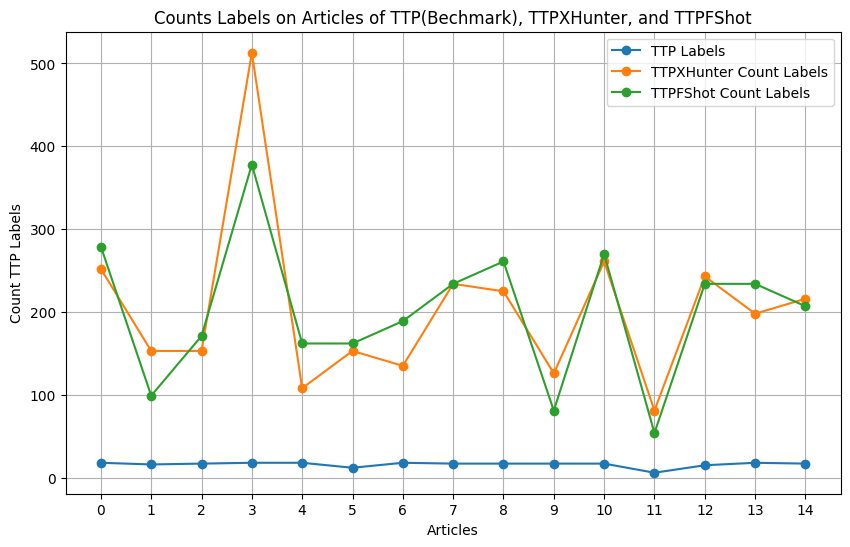

In [61]:
import matplotlib.pyplot as plt
import numpy as np


# Calculate the counts and store in a new DataFrame
df_reports_plot = pd.DataFrame({
    'TTP_count': df_reports['TTP'].apply(lambda x: len(x)),
    'ttpxhunter_count': df_reports['ttpxhunter'].apply(lambda x: len(x)),
    'ttfshot_count': df_reports['ttfshot'].apply(lambda x: len(x))
})

df_reports_plot.reset_index(drop=True, inplace=True)
# Ensure the counts are one-dimensional arrays
TTP_count = df_reports_plot['TTP_count'].to_numpy()
ttpxhunter_count = df_reports_plot['ttpxhunter_count'].to_numpy()
ttfshot_count = df_reports_plot['ttfshot_count'].to_numpy()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_reports_plot.index.to_numpy(), TTP_count, marker='o', label='TTP Labels')
plt.plot(df_reports_plot.index.to_numpy(), ttpxhunter_count, marker='o', label='TTPXHunter Count Labels')
plt.plot(df_reports_plot.index.to_numpy(), ttfshot_count, marker='o', label='TTPFShot Count Labels')

# Adding titles and labels
plt.title('Counts Labels on Articles of TTP(Bechmark), TTPXHunter, and TTPFShot')
plt.xlabel('Articles')
plt.ylabel('Count TTP Labels')
plt.xticks(df_reports_plot.index)  # Ensure all indices are shown on x-axis
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [39]:

df_reports_plot.index.to_numpy()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [48]:
df_reports

,Unnamed: 0,RawText,TTP,CleanText,ttpxhunter,ttfshot,ttfshot2,TTP_count,ttpxhunter_count,ttfshot_count
0,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{1, 7, 2, A, ,, 9, 3, 5, ', ., T, 8, 4, }, 0, ...",\n\n\n\n\n\n\nActions to take today to mitigat...,"[T1567, T1029, T1490, T1140, T1542, T1560, T14...","{T1016, T1566, T1518, T1069, T1542, T1560, T10...",,495,28,31
1,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\nHow SVR-Attributed Actors are Adapting...,"{1, 2, 7, ,, 9, 5, ', ., T, 8, 4, }, 0, , {, 6}",\n\n\n\nHow SVR-Attributed Actors are Adapting...,"[T1535, T1087, T1119, T1526, T1136, T1014, T15...","{T1110, T1036, T1071, T1105, T1033, T1553, T10...",,66,17,11
2,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{1, 2, 7, ,, 9, 3, 5, ', ., T, 8, 4, }, 0, , ...",\n\n\n\n\n\n\nActions to take today to mitigat...,"[T1087, T1557, T1610, T1190, T1069, T1613, T15...","{T1016, T1566, T1518, T1069, T1564, T1055, T15...",,158,17,19
3,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{1, 7, 2, ,, 9, 3, 5, ', ., T, 8, 4, 6, }, 0, ...",\n\n\n\n\n\n\nActions to take today to mitigat...,"[T1535, T1129, T1490, T1056, T1069, T1199, T15...","{T1016, T1056, T1518, T1069, T1589, T1090, T11...",,786,57,42
4,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{1, 2, 7, ,, 9, 5, 3, ', ., T, 8, 4, 6, }, 0, ...",\n\n\n\n\n\n\nActions to take today to mitigat...,"[T1594, T1071, T1573, T1530, T1593, T1553, T11...","{T1518, T1102, T1583, T1105, T1078, T1555, T10...",,173,12,18
5,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{1, 7, ,, 9, 5, ', }, T, 8, , {, 6}",\n\n\n\n\n\n\nActions to take today to mitigat...,"[T1562, T1070, T1598, T1119, T1048, T1566, T15...","{T1566, T1518, T1090, T1102, T1041, T1486, T11...",,45,17,18
6,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to mitigat...,"{1, 2, 7, A, 9, ,, 5, 3, ', ., T, 8, 4, }, 0, ...",\n\n\n\n\n\n\nActions to take today to mitigat...,"[T1070, T1029, T1119, T1190, T1566, T1518, T10...","{T1566, T1518, T1069, T1090, T1560, T1486, T10...",,174,15,21
7,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\n\n\n\nActions to take today to harden ...,"{1, 2, 7, ,, 9, 3, 5, ', ., T, 8, 4, }, 0, , ...",\n\n\n\n\n\n\nActions to take today to harden ...,"[T1535, T1069, T1550, T1003, T1027, T1531, T16...","{T1566, T1056, T1069, T1518, T1090, T1102, T15...",,304,26,26
8,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\nSUMMARY\nThe U.S. Federal Bureau of In...,"{1, 2, 7, ,, 9, 3, 5, ', ., T, 8, 4, }, 0, , ...",\n\n\n\nSUMMARY\nThe U.S. Federal Bureau of In...,"[T1518, T1140, T1564, T1560, T1482, T1550, T10...","{T1566, T1518, T1203, T1102, T1560, T1055, T10...",,371,25,29
9,https://www.cisa.gov/news-events/cybersecurity...,\n\n\n\nThe Russia-based actor is targeting or...,"{1, 2, 7, ,, 9, 5, 3, ', ., T, 8, 4, }, 0, , ...",\n\n\n\nThe Russia-based actor is targeting or...,"[T1114, T1195, T1204, T1199, T1531, T1565, T15...","{T1036, T1114, T1566, T1204, T1586, T1564, T15...",,153,14,9


### TTPXHunter Evaluation

In [71]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Convert columns to lists of sets
y_true = df_reports['TTP'].apply(eval).tolist()  # Convert strings to sets
y_pred = df_reports['ttpxhunter'].tolist()

# Define all unique TTPs across the entire dataset
all_ttps = set.union(*y_true, *y_pred)

# Use MultiLabelBinarizer to transform labels
mlb = MultiLabelBinarizer(classes=list(all_ttps))
y_true_bin = mlb.fit_transform(y_true)
y_pred_bin = mlb.transform(y_pred)

from sklearn.metrics import accuracy_score

subset_accuracy = accuracy_score(y_true_bin, y_pred_bin)
print("Subset Accuracy:", subset_accuracy)

from sklearn.metrics import hamming_loss

hamming_acc = 1 - hamming_loss(y_true_bin, y_pred_bin)
print("Hamming Accuracy:", hamming_acc)

from sklearn.metrics import f1_score

f1_micro = f1_score(y_true_bin, y_pred_bin, average='micro')
print("F1 Score (Micro):", f1_micro)

f1_macro = f1_score(y_true_bin, y_pred_bin, average='macro')
print("F1 Score (Macro):", f1_macro)

from sklearn.metrics import precision_score, recall_score

# Calculate precision
precision_micro = precision_score(y_true_bin, y_pred_bin, average='micro')
precision_macro = precision_score(y_true_bin, y_pred_bin, average='macro')

print("Precision (Micro):", precision_micro)
print("Precision (Macro):", precision_macro)

# Calculate recall
recall_micro = recall_score(y_true_bin, y_pred_bin, average='micro')
recall_macro = recall_score(y_true_bin, y_pred_bin, average='macro')

print("Recall (Micro):", recall_micro)
print("Recall (Macro):", recall_macro)


Subset Accuracy: 0.0
Hamming Accuracy: 0.8183406113537117
F1 Score (Micro): 0.13692946058091288
F1 Score (Macro): 0.06901989325570111
Precision (Micro): 0.14473684210526316
Precision (Macro): 0.06784154709918902
Recall (Micro): 0.12992125984251968
Recall (Macro): 0.08689956331877728


/home/hamzicd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### TTP-FShooter Evaluation

In [72]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Convert columns to lists of sets
y_true = df_reports['TTP'].apply(eval).tolist()  # Convert strings to sets
y_pred = df_reports['ttfshot'].tolist()

# Define all unique TTPs across the entire dataset
all_ttps = set.union(*y_true, *y_pred)

# Use MultiLabelBinarizer to transform labels
mlb = MultiLabelBinarizer(classes=list(all_ttps))
y_true_bin = mlb.fit_transform(y_true)
y_pred_bin = mlb.transform(y_pred)

from sklearn.metrics import accuracy_score

subset_accuracy = accuracy_score(y_true_bin, y_pred_bin)
print("Subset Accuracy:", subset_accuracy)

from sklearn.metrics import hamming_loss

hamming_acc = 1 - hamming_loss(y_true_bin, y_pred_bin)
print("Hamming Accuracy:", hamming_acc)

from sklearn.metrics import f1_score

f1_micro = f1_score(y_true_bin, y_pred_bin, average='micro')
print("F1 Score (Micro):", f1_micro)

f1_macro = f1_score(y_true_bin, y_pred_bin, average='macro')
print("F1 Score (Macro):", f1_macro)

from sklearn.metrics import precision_score, recall_score

# Calculate precision
precision_micro = precision_score(y_true_bin, y_pred_bin, average='micro')
precision_macro = precision_score(y_true_bin, y_pred_bin, average='macro')

print("Precision (Micro):", precision_micro)
print("Precision (Macro):", precision_macro)

# Calculate recall
recall_micro = recall_score(y_true_bin, y_pred_bin, average='micro')
recall_macro = recall_score(y_true_bin, y_pred_bin, average='macro')

print("Recall (Micro):", recall_micro)
print("Recall (Macro):", recall_macro)

Subset Accuracy: 0.0
Hamming Accuracy: 0.8272277227722773
F1 Score (Micro): 0.24622030237580994
F1 Score (Macro): 0.10593273613075593
Precision (Micro): 0.2727272727272727
Precision (Macro): 0.10446133899104196
Recall (Micro): 0.22440944881889763
Recall (Macro): 0.14661716171617162


/home/hamzicd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### V2 - FewShot- Multiple Labels

In [117]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Convert columns to lists of sets
y_true = df_reports['TTP'].apply(eval).tolist()  # Convert strings to sets
y_pred = df_reports['ttfshot2'].tolist()

# Define all unique TTPs across the entire dataset
all_ttps = set.union(*y_true, *y_pred)

# Use MultiLabelBinarizer to transform labels
mlb = MultiLabelBinarizer(classes=list(all_ttps))
y_true_bin = mlb.fit_transform(y_true)
y_pred_bin = mlb.transform(y_pred)

from sklearn.metrics import accuracy_score

subset_accuracy = accuracy_score(y_true_bin, y_pred_bin)
print("Subset Accuracy:", subset_accuracy)

from sklearn.metrics import hamming_loss

hamming_acc = 1 - hamming_loss(y_true_bin, y_pred_bin)
print("Hamming Accuracy:", hamming_acc)

from sklearn.metrics import f1_score

f1_micro = f1_score(y_true_bin, y_pred_bin, average='micro')
print("F1 Score (Micro):", f1_micro)

f1_macro = f1_score(y_true_bin, y_pred_bin, average='macro')
print("F1 Score (Macro):", f1_macro)

from sklearn.metrics import precision_score, recall_score

# Calculate precision
precision_micro = precision_score(y_true_bin, y_pred_bin, average='micro')
precision_macro = precision_score(y_true_bin, y_pred_bin, average='macro')

print("Precision (Micro):", precision_micro)
print("Precision (Macro):", precision_macro)

# Calculate recall
recall_micro = recall_score(y_true_bin, y_pred_bin, average='micro')
recall_macro = recall_score(y_true_bin, y_pred_bin, average='macro')

print("Recall (Micro):", recall_micro)
print("Recall (Macro):", recall_macro)

Subset Accuracy: 0.0
Hamming Accuracy: 0.8295546558704454
F1 Score (Micro): 0.21601489757914338
F1 Score (Macro): 0.0849367007261744
Precision (Micro): 0.2049469964664311
Precision (Macro): 0.07698252040357303
Recall (Micro): 0.2283464566929134
Recall (Macro): 0.12597840755735493


/home/hamzicd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### V2 - FewShot- CoT

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Convert columns to lists of sets
y_true = df_reports['TTP'].apply(eval).tolist()  # Convert strings to sets
y_pred = df_reports['ttpxhunter'].tolist()

# Define all unique TTPs across the entire dataset
all_ttps = set.union(*y_true, *y_pred)

# Use MultiLabelBinarizer to transform labels
mlb = MultiLabelBinarizer(classes=list(all_ttps))
y_true_bin = mlb.fit_transform(y_true)
y_pred_bin = mlb.transform(y_pred)

from sklearn.metrics import accuracy_score

subset_accuracy = accuracy_score(y_true_bin, y_pred_bin)
print("Subset Accuracy:", subset_accuracy)

from sklearn.metrics import hamming_loss

hamming_acc = 1 - hamming_loss(y_true_bin, y_pred_bin)
print("Hamming Accuracy:", hamming_acc)

from sklearn.metrics import f1_score

f1_micro = f1_score(y_true_bin, y_pred_bin, average='micro')
print("F1 Score (Micro):", f1_micro)

f1_macro = f1_score(y_true_bin, y_pred_bin, average='macro')
print("F1 Score (Macro):", f1_macro)

from sklearn.metrics import precision_score, recall_score

# Calculate precision
precision_micro = precision_score(y_true_bin, y_pred_bin, average='micro')
precision_macro = precision_score(y_true_bin, y_pred_bin, average='macro')

print("Precision (Micro):", precision_micro)
print("Precision (Macro):", precision_macro)

# Calculate recall
recall_micro = recall_score(y_true_bin, y_pred_bin, average='micro')
recall_macro = recall_score(y_true_bin, y_pred_bin, average='macro')

print("Recall (Micro):", recall_micro)
print("Recall (Macro):", recall_macro)

print("-----------------------")

# Convert columns to lists of sets
y_true = df_reports['TTP'].apply(eval).tolist()  # Convert strings to sets
y_pred = df_reports['ttfshot'].tolist()

# Define all unique TTPs across the entire dataset
all_ttps = set.union(*y_true, *y_pred)

# Use MultiLabelBinarizer to transform labels
mlb = MultiLabelBinarizer(classes=list(all_ttps))
y_true_bin = mlb.fit_transform(y_true)
y_pred_bin = mlb.transform(y_pred)

from sklearn.metrics import accuracy_score

subset_accuracy = accuracy_score(y_true_bin, y_pred_bin)
print("Subset Accuracy:", subset_accuracy)

from sklearn.metrics import hamming_loss

hamming_acc = 1 - hamming_loss(y_true_bin, y_pred_bin)
print("Hamming Accuracy:", hamming_acc)

from sklearn.metrics import f1_score

f1_micro = f1_score(y_true_bin, y_pred_bin, average='micro')
print("F1 Score (Micro):", f1_micro)

f1_macro = f1_score(y_true_bin, y_pred_bin, average='macro')
print("F1 Score (Macro):", f1_macro)

from sklearn.metrics import precision_score, recall_score

# Calculate precision
precision_micro = precision_score(y_true_bin, y_pred_bin, average='micro')
precision_macro = precision_score(y_true_bin, y_pred_bin, average='macro')

print("Precision (Micro):", precision_micro)
print("Precision (Macro):", precision_macro)

# Calculate recall
recall_micro = recall_score(y_true_bin, y_pred_bin, average='micro')
recall_macro = recall_score(y_true_bin, y_pred_bin, average='macro')

print("Recall (Micro):", recall_micro)
print("Recall (Macro):", recall_macro)

Subset Accuracy: 0.0
Hamming Accuracy: 0.8427622841965472
F1 Score (Micro): 0.13702623906705538
F1 Score (Macro): 0.06793676664194592
Precision (Micro): 0.13864306784660768
Precision (Macro): 0.06692278505027507
Recall (Micro): 0.13544668587896252
Recall (Macro): 0.09424207930184025
-----------------------
Subset Accuracy: 0.0
Hamming Accuracy: 0.8449339207048459
F1 Score (Micro): 0.22580645161290322
F1 Score (Macro): 0.09221031049224883
Precision (Micro): 0.2298507462686567
Precision (Macro): 0.08988478481870552
Recall (Micro): 0.2219020172910663
Recall (Macro): 0.14023494860499267


/home/hamzicd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/py